# Setup

## Load Modules

In [1]:
%matplotlib notebook

# Standard library
import os.path, logging, collections

# External modules
from neuron import h
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import bluepyopt.ephys as ephys

# Our modules
from bgcellmodels.common import electrotonic, treeutils, analysis, logutils
from bgcellmodels.morphology import morph_ni, morph_gui

from bgcellmodels.models.STN import GilliesWillshaw as gillies
from bgcellmodels.models.STN import Miocinovic2006 as miocinovic
from bgcellmodels.models.axon.mcintyre2002 import AxonMcintyre2002

## Settings

In [2]:
gillies.load_mechanisms()
default_template = 'STN_morph_arcdist'

class CellModel(object):
    """ Wrapper class to store NEURON cell data. """
    pass

# Global variables
nrnsim = ephys.simulators.NrnSimulator(dt=0.025, cvode_active=False)

logger = logging.getLogger('STN_MORPH')
logger.setLevel(logging.DEBUG)
logging.basicConfig(format=logutils.DEFAULT_FORMAT)

In [3]:
# Plotting options
page_width = 5.0
fig_aspect_ratio = 2.2 # 8.0 / 3.0
fig_width = 0.8 * page_width
fig_height = fig_width / fig_aspect_ratio

# Style of figures (default colors etc.): see https://matplotlib.org/gallery/style_sheets/style_sheets_reference.html
plt.style.use('default')

# fix bug for notebook backend where figures not shown
if matplotlib.get_backend() == 'nbAgg':
    from bgcellmodels.extensions.jupyter import jupyterutil
    jupyterutil.notebook_show_figs_after_exception()

## Functions

In [4]:
def template_with_morphology(
        template_name, morphology_path,
        streamlines_path, streamline_index=0):
    """
    Instantiate template with given morphology and axon
    """
    miocinovic.load_template(template_name) # xopen -> loads once
    template_constructor = getattr(h, template_name)
    
    # Instantiate template
    icell = template_constructor()
    icell.with_extracellular = 0
    
    wrapper = CellModel()
    wrapper.icell = icell

    # Load morphology into template
    morphology = ephys.morphologies.NrnFileMorphology(morphology_path, do_replace_axon=False)
    morphology.instantiate(sim=nrnsim, icell=icell)

    # Setup biophysical properties
    icell.del_unused_sections()
    icell.insert_biophys()
    nseg_extra = electrotonic.set_min_nseg_hines(icell.all, f_lambda=100.0)
    print("Created {} extra segments to satisfy Hines' rule".format(nseg_extra))
    icell.set_biophys_spatial()

    if streamlines_path is not None:
        # Load axon coordinates
        axon_builder = AxonMcintyre2002(logger=logger)
        tracks_coords = morph_ni.load_streamlines(streamlines_path, max_num=1, min_length=2.0)
        axon_coords = tracks_coords[0]

        # Build axon
        axon_initial_secs = list(icell.axonal)
        axon_terminal_secs = treeutils.leaf_sections(axon_initial_secs[0], subtree=True)
        assert len(axon_terminal_secs) == 1
        axon_end_sec = axon_terminal_secs[0]

        axon = axon_builder.build_along_streamline(axon_coords,
                    terminate='nodal_cutoff', interp_method='cartesian',
                    parent_cell=icell, parent_sec=axon_end_sec,
                    connection_method='translate_axon_start')
    
        wrapper.axon = axon

    return wrapper


def template_predefined_morphology(template_name='STN_morph_type1RD', with_extracellular=False):
    """
    Load template with built-in morphology.
    """
    miocinovic.load_template(template_name) # xopen -> loads once
    template_constructor = getattr(h, template_name)
    
    # Instantiate template
    icell = template_constructor(with_extracellular)
    return icell

In [5]:
electrotonic_measures = {
    'Ztransfer': {
        'function': electrotonic.measure_transfer_impedance,
        'label': 'Transfer impedance',
        'units': 'Ohm',
    },
    'Ai': {
        'function': electrotonic.measure_current_transfer,
        'label': 'Current transfer ratio',
        'units': 'ratio',
    },
    'Av': {
        'function': electrotonic.measure_voltage_transfer,
        'label': 'Voltage transfer ratio',
        'units': 'ratio',
    },
    'Zin': {
        'function': electrotonic.measure_input_impedance,
        'label': 'Input impedance',
        'units': 'Ohm',
    }
}

def plot_electrotonic_structure(root, leaves, measures=None, freq=25.0):
    """
    Plot electrotonic properties along dendritic paths.
    """
    if measures is None:
        plotted_measures = electrotonic_measures.keys()
    else:
        plotted_measures = measures
    measure_funcs = {measure: electrotonic_measures[measure]['function'] for measure in plotted_measures}
        
    # Do measurement
    leaf_path_measurements = electrotonic.measure_along_paths(root, leaves, measure_funcs, freq=freq)

    # Plot measurements
    fig, axes = plt.subplots(len(plotted_measures))

#     measures_ylims = {
#         'Ztransfer': (0, 50),
#         'Ai': (0.5, 1.05),
#         'Av': (0, 1.1),
#         'Zin': (0, 1000.0),
#     }

    for i, measure in enumerate(plotted_measures):
        ax = axes[i]

        # Plot the same measure for each leaf in the same axis
        for j, leaf in enumerate(leaves):
            ax.plot(leaf_path_measurements[j]['pathlen_micron'],
                    leaf_path_measurements[j][measure],
                    label=leaf.name())

            # ax.set_ylim(measures_ylims[measure])
            # ax.legend()
            ax.grid(True)
            ax.set_ylabel('{} ({})'.format(measure, electrotonic_measures[measure]['units']))
            ax.set_title(electrotonic_measures[measure]['label'])
    
    # prevent clipped xlabel
    # fig.subplots_adjust(hspace=0.5)
    # fig.tight_layout()
    return leaf_path_measurements

In [6]:
def setup_protocol_SPONT():
    pass

def setup_protocol_REBOUND():
    pass

def setup_protocol_PLATEAU():
    pass

# Gillies (2005)

## Make Cell

In [6]:
gillies.load_template('STN_gillies_network')
icell = h.make_stn_cell_ref()

soma = icell.soma[0]
dendritic = list(icell.basal)

distal_seg = dendritic[8](0.75)
middle_seg = dendritic[20](0.25)
proximal_seg = dendritic[24](0.5)

	1 
	1 
 
loading STh cell data structures...
 
	1 
	1 
  2 trees
  loaded tree 0 (23 branches)
  loaded tree 1 (11 branches)
	1 


In [7]:
# TODO: look in calibrate_synapses_STN.ipynb, stn_model_evaluation.py, proto_gillies_article.py
rec_secs = {
    'soma': soma,
    'prox': proximal_seg,
    'mid': middle_seg,
    'dist': distal_seg,
}

trace_specs = collections.OrderedDict([
    ('V_soma', {'var':'v', 'sec':'soma', 'loc':0.5}),
    ('V_prox', {'var':'v', 'seg':'prox'}),
    ('V_mid', {'var':'v', 'seg':'mid'}),
    ('V_dist', {'var':'v', 'seg':'dist'}),
])

# Record
rec_dt = 0.05
vec_dict, markers = analysis.recordTraces(rec_secs, trace_specs, rec_dt)

## Cell Properties

In [8]:
leaves = treeutils.leaf_sections(list(icell.basal)[0], subtree=True)
root = soma

Somatic input impedances are: 

	Zin(f=0.0) = 137.342928013 (MOhm)
	Zin(f=100.0) = 30.3541377672 (MOhm)


<IPython.core.display.Javascript object>


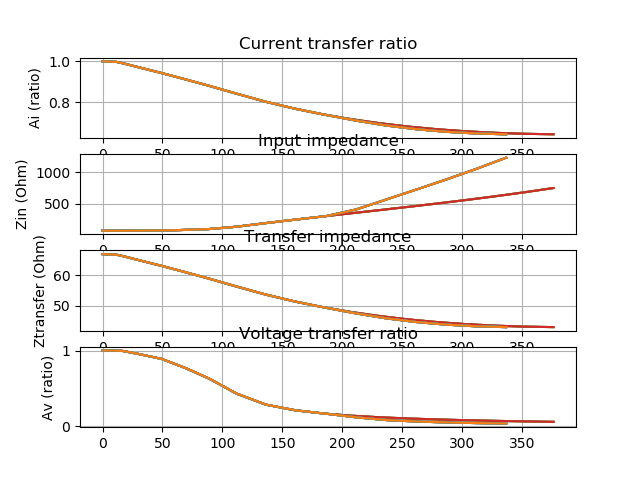

[{'Ai': [1.0000000000000002,
   0.9965129676092102,
   0.990282901791316,
   0.971757561040051,
   0.9425003051217583,
   0.9115452513969049,
   0.879716843201494,
   0.8430206962656586,
   0.8041875499867278,
   0.770714091590952,
   0.7421703984653599,
   0.7181289634369666,
   0.6981729080062317,
   0.681906039674937,
   0.6689637628147438,
   0.6590238383268737,
   0.6518161417672861,
   0.6471308210849155,
   0.6448245174273736],
  'Av': [1.0000000000000002,
   0.9978066644436977,
   0.9938152468838759,
   0.9564002242470103,
   0.888474390198799,
   0.7673641123308811,
   0.6256102690779363,
   0.4337072785603913,
   0.28771321492173263,
   0.21317846374590863,
   0.16839780530580478,
   0.13856281319156105,
   0.11724110015450215,
   0.10121447223402545,
   0.08870101986698711,
   0.07863651576033413,
   0.07034708688444519,
   0.06338576279297968,
   0.057444701012395925],
  'Zin': [66.8001680264702,
   66.71355889766944,
   66.56273833674635,
   67.8728075472544,
   70.8621198

In [9]:
soma_Zin = {
    f : electrotonic.measure_input_impedance(soma(0.5), freq=f, linearize_gating=False)
                for f in (0.0, 100.0)
}

print("Somatic input impedances are: \n\n\t" + "\n\t".join(
        ["Zin(f={}) = {} (MOhm)".format(f, Z) for f,Z in soma_Zin.items()]))

measurements = plot_electrotonic_structure(root, leaves)

## Protocol SPONT

In [9]:
# Gillies (2006) - Fig. 3.B (25 deg, 8Hz), 3.C (35 deg, 12 Hz)
h.cvode_active(0)
h.dt = 0.025
h.tstop = 2000

h.celsius = 35 # different temp from paper (fig 3B: 25degC, fig. 3C: 35degC)
h.v_init = -60 # paper simulations use default v_init
h.set_aCSF(4) # Set initial ion concentrations from Bevan & Wilson (1999)

h.init()
h.run()

Setting in vitro parameters based on Bevan & Wilson (1999)


0.0

<IPython.core.display.Javascript object>


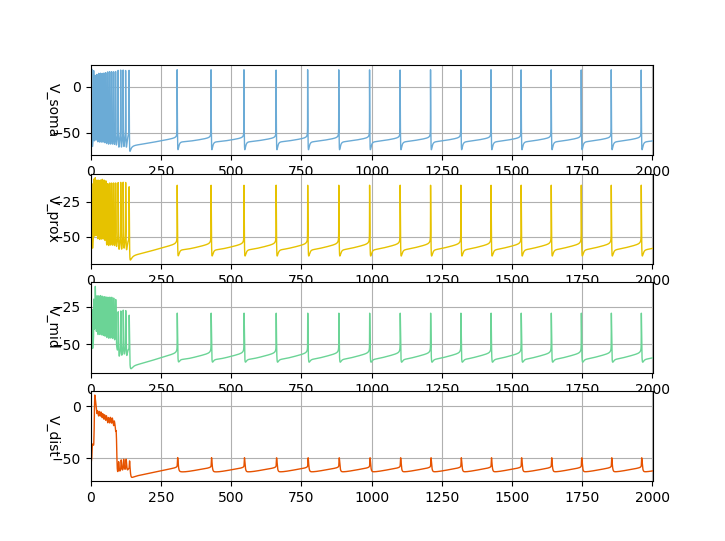

In [10]:
figs_vm = analysis.plotTraces(vec_dict, rec_dt, traceSharex=True)

## Protocol REBOUND

In [27]:
# Gillies (2006) - Fig. 3.D, 4 (altered conductances)
# Original code used -0.25 nA current to hyperpolarize to -75 mV steady state
clamp = h.SEClamp(soma(0.5))
clamp.dur1 = 0
clamp.dur2 = 0
clamp.dur3 = 500
clamp.amp3 = -75

In [28]:
h.dt = 0.025
h.tstop = 2000

h.celsius = 35 # different temp from paper (fig 3B: 25degC, fig. 3C: 35degC)
h.v_init = -60 # paper simulations use default v_init
h.set_aCSF(4) # Set initial ion concentrations from Bevan & Wilson (1999)

h.init()
h.run()

Setting in vitro parameters based on Bevan & Wilson (1999)


0.0

<IPython.core.display.Javascript object>


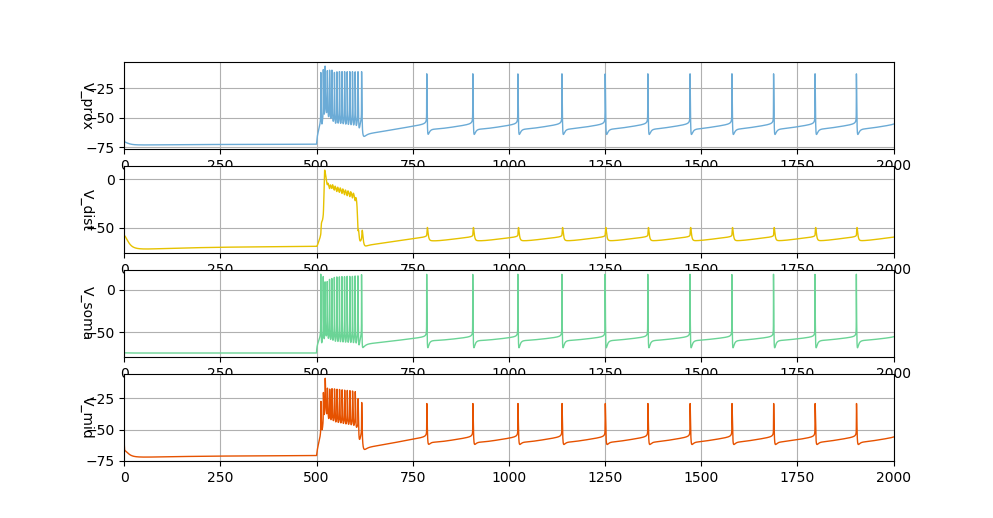

In [29]:
figs_vm = analysis.plotTraces(vec_dict, rec_dt, traceSharex=True)

## Protocol PLATEAU

In [11]:
# Gillies (2006) - Fig. 10.C
# Protocol: hyperpolarization to -70 mV using constant current,
# then apply 0.2 nA, 50 ms depolarizing pulse, return to constant hyperpolarizing current

# Current clamp parameters
amp_hyper = -0.17           # SETPARAM: adjust amplitude for hyperpolarizing to - 70 mV
amp_pulse = amp_hyper + 0.2 # SETPARAM: adjust depolarizing pulse amplitude based on input resistance

dur_pulse = 50 
del_pulse = 1000

# Make current clamps
try:
    del clamp
except NameError:
    pass
stim1, stim2, stim3 = [h.IClamp(soma(0.5)) for i in range(3)]

stim1.delay = 0
stim1.dur = del_pulse
stim1.amp = amp_hyper

stim2.delay = del_pulse
stim2.dur = dur_pulse
stim2.amp = amp_pulse

stim3.delay = del_pulse + dur_pulse
stim3.dur = h.tstop - stim3.delay
stim3.amp = amp_hyper

In [12]:
h.dt = 0.025
h.tstop = 1500

h.celsius = 30 # different temp from paper (fig 3B: 25degC, fig. 3C: 35degC)
h.v_init = -60 # paper simulations use default v_init
h.set_aCSF(4) # Set initial ion concentrations from Bevan & Wilson (1999)

h.init()
h.run()

Setting in vitro parameters based on Bevan & Wilson (1999)


0.0

<IPython.core.display.Javascript object>


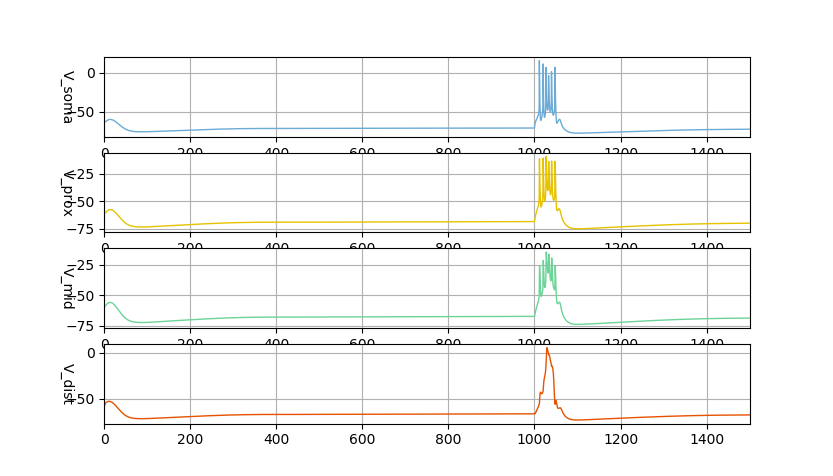

In [13]:
figs_vm = analysis.plotTraces(vec_dict, rec_dt, traceSharex=True)

# Miocinovic (2006)

## Make Cell

In [7]:
#########################################################
# GENERIC TEMPLATE

morphology_path = os.path.join(miocinovic.pkg_dir, 'morphologies/type1RD_axonless-with-AIS.swc')
streamlines_path = '/home/luye/Documents/mri_data/Waxholm_rat_brain_atlas/WHS_DTI_v1_ALS/S56280_track_filter-ROI-STN.tck'

streamlines_path = None
template_name = 'STN_morph_arcdist' # default_template, 'STN_morph_cartdist', STN_morph_arcdist

model = template_with_morphology(
                template_name, morphology_path,
                streamlines_path, streamline_index=0)

icell = model.icell

#########################################################
# PREDEFINED TEMPLATE

# icell = template_predefined_morphology()

#########################################################
# Verify axon creation:
# print(list(icell.axonal))
# h.topology()

One point section Import3d_Section[1] ending at line 2 has been removed
	and child Import3d_Section[24] reattached
Created 21 extra segments to satisfy Hines' rule
maximum dendrite length in STN_morph_arcdist[0]  is 857.16795 


In [11]:
soma = icell.soma[0]
dendritic = list(icell.basal)

distal_seg = icell.dend[59](0.9) # 15,19,21,26,58,59,49,60,51
middle_seg = icell.dend[31](0.5) # 57, 31, 12
proximal_seg = icell.dend[8](0.2) # 8, 22, 29, 42

# axon_leaf_secs = treeutils.leaf_sections(list(icell.axonal)[0], subtree=True)
dend_leaf_secs = treeutils.leaf_sections(soma, subtree=True)
leaves = dend_leaf_secs
root = icell.soma[0]

In [9]:
rec_secs = {
    'soma': soma,
    'prox': proximal_seg,
    'mid': middle_seg,
    'dist': distal_seg,
}

trace_specs = collections.OrderedDict([
    ('V_soma', {'var':'v', 'sec':'soma', 'loc':0.5}),
    ('V_prox', {'var':'v', 'seg':'prox'}),
    ('V_mid', {'var':'v', 'seg':'mid'}),
    ('V_dist', {'var':'v', 'seg':'dist'}),
])

# Record
rec_dt = 0.05
vec_dict, markers = analysis.recordTraces(rec_secs, trace_specs, rec_dt)

## Cell Properties

In [9]:
# from neuron import gui

In [ ]:
# First draw skeleton to get an idea
# plt.figure()
# ax = plt.subplot(111, projection='3d')
# ax.view_init(90,90) # set azimut and elevation
# ax.set_zlim((-1,1)) # prevent rounding errors
# ax.set_axis_off() # hide x,y,z axes and grid

# # center = np.array([h.x3d(0, sec=soma), h.y3d(0, sec=soma), h.z3d(0, sec=soma)])
# x_soma = h.x3d(0, sec=soma)
# y_soma = h.y3d(0, sec=soma)
# ax.set_xlim((x_soma-200, x_soma+200))
# ax.set_ylim((y_soma-200, y_soma+200))


# # Plot shape of our cell
# morph_gui.shapeplot(h, ax)

# # Mark location of leaf section to refer to plots
# marker_colors = 'rgby'
# for i, leaf_sec in enumerate(leaves):
#     morph_gui.mark_locations(h, leaf_sec, 1.0, 
#                              label=leaf_sec.name(),
#                              markspec='o'+marker_colors[i])

# plt.legend()
# plt.show()

Somatic input impedances are: 

	Zin(f=0.0) = 48.2024535753 (MOhm)
	Zin(f=100.0) = 11.986329287 (MOhm)


<IPython.core.display.Javascript object>


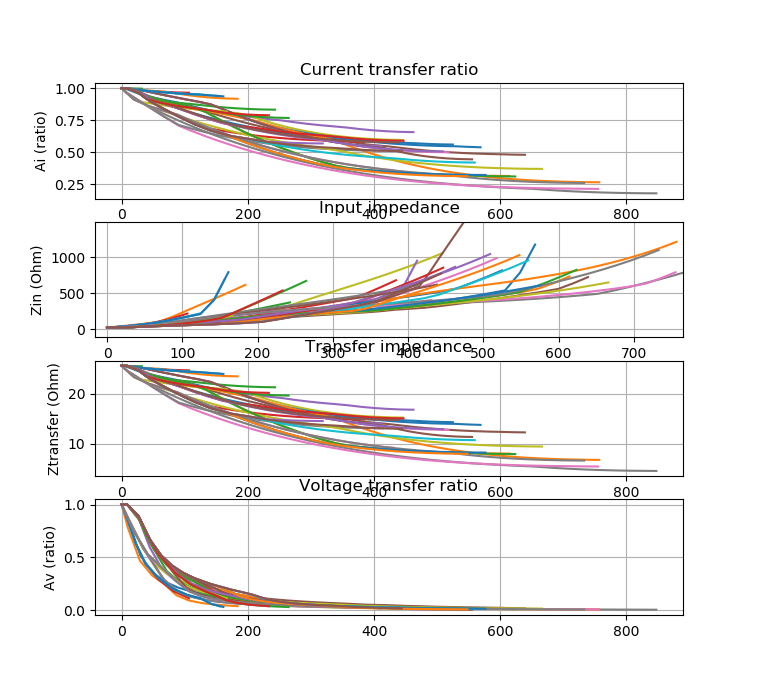

In [12]:
soma_Zin = {
    f : electrotonic.measure_input_impedance(soma(0.5), freq=f, linearize_gating=False)
                for f in (0.0, 100.0)
}

print("Somatic input impedances are: \n\n\t" + "\n\t".join(
        ["Zin(f={}) = {} (MOhm)".format(f, Z) for f,Z in soma_Zin.items()]))

measurements = plot_electrotonic_structure(root, leaves)

## Protocol SPONT

In [13]:
# Gillies (2006) - Fig. 3.B (25 deg, 8Hz), 3.C (35 deg, 12 Hz)
h.cvode_active(0)
h.dt = 0.025
h.tstop = 2000

h.celsius = 35 # different temp from paper (fig 3B: 25degC, fig. 3C: 35degC)
h.v_init = -60 # paper simulations use default v_init
# h.set_aCSF(4) # Set initial ion concentrations from Bevan & Wilson (1999)

h.init()
h.run()

0.0

<IPython.core.display.Javascript object>


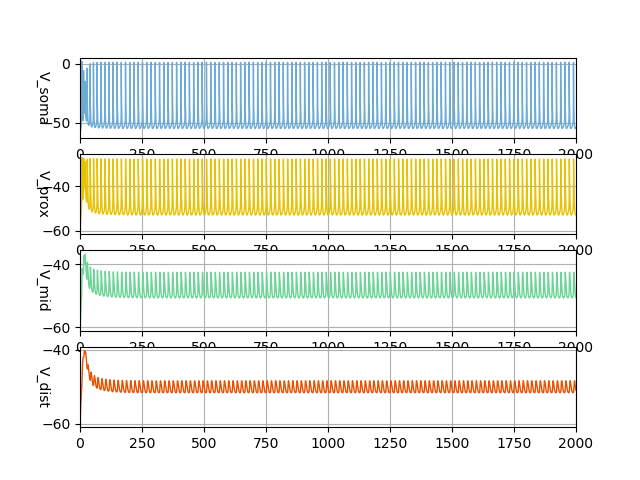

In [14]:
figs_vm = analysis.plotTraces(vec_dict, rec_dt, traceSharex=True)

## Protocol REBOUND

In [15]:
# Gillies (2006) - Fig. 3.D, 4 (altered conductances)
# Original code used -0.25 nA current to hyperpolarize to -75 mV steady state
clamp = h.SEClamp(soma(0.5))
clamp.dur1 = 0
clamp.dur2 = 0
clamp.dur3 = 500
clamp.amp3 = -75

In [16]:
h.dt = 0.025
h.tstop = 2000

h.celsius = 35 # different temp from paper (fig 3B: 25degC, fig. 3C: 35degC)
h.v_init = -60 # paper simulations use default v_init
# h.set_aCSF(4) # Set initial ion concentrations from Bevan & Wilson (1999)

h.init()
h.run()

0.0

<IPython.core.display.Javascript object>


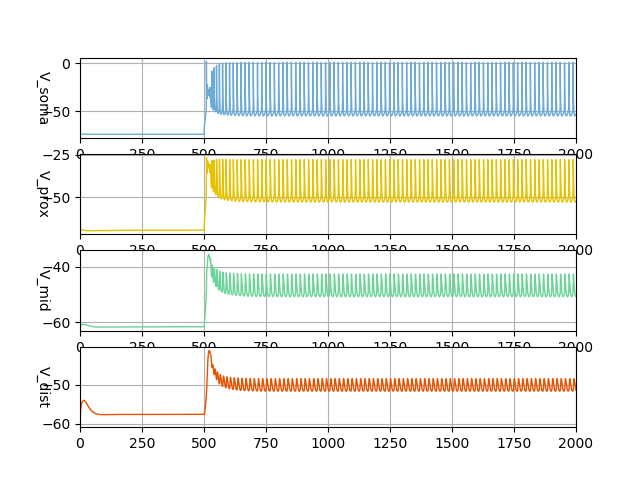

In [17]:
figs_vm = analysis.plotTraces(vec_dict, rec_dt, traceSharex=True)

## Protocol PLATEAU

In [18]:
# Gillies (2006) - Fig. 10.C
# Protocol: hyperpolarization to -70 mV using constant current,
# then apply 0.2 nA, 50 ms depolarizing pulse, return to constant hyperpolarizing current

# Current clamp parameters
amp_hyper = -0.17           # SETPARAM: adjust amplitude for hyperpolarizing to - 70 mV
amp_pulse = amp_hyper + 0.2 # SETPARAM: adjust depolarizing pulse amplitude based on input resistance

dur_pulse = 50 
del_pulse = 1000

# Make current clamps
try:
    del clamp
except NameError:
    pass
stim1, stim2, stim3 = [h.IClamp(soma(0.5)) for i in range(3)]

stim1.delay = 0
stim1.dur = del_pulse
stim1.amp = amp_hyper

stim2.delay = del_pulse
stim2.dur = dur_pulse
stim2.amp = amp_pulse

stim3.delay = del_pulse + dur_pulse
stim3.dur = h.tstop - stim3.delay
stim3.amp = amp_hyper

In [19]:
h.dt = 0.025
h.tstop = 1500

h.celsius = 30 # different temp from paper (fig 3B: 25degC, fig. 3C: 35degC)
h.v_init = -60 # paper simulations use default v_init
# h.set_aCSF(4) # Set initial ion concentrations from Bevan & Wilson (1999)

h.init()
h.run()

0.0

<IPython.core.display.Javascript object>


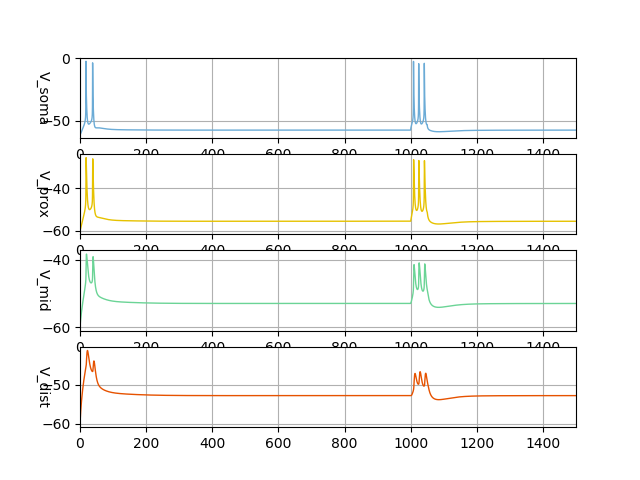

In [20]:
figs_vm = analysis.plotTraces(vec_dict, rec_dt, traceSharex=True)

# Bevan, Chu (2016)

Can be found on neuromorpho.org using following searches
- [keyword 'subthalamic', sorty by archive](http://neuromorpho.org/KeywordBrowseView.jsp?count=52&keywords=%22subthalamic%22&browseBy=archive)
- [search by brain region 'basal ganglia'](http://neuromorpho.org/byregion.jsp#top)

# Save Notebook

In [ ]:
%%javascript
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});

In [22]:
from datetime import datetime
nb_filename = 'calibrate_morphologies_STN.ipynb'
report_filename = 'calibrate_morphologies_STN_{}_{}.html'.format(
    template_name, datetime.now().strftime('%Y.%m.%d_%H.%M.%S'))
!jupyter nbconvert $nb_filename --to html --template=toc2 --output $report_filename

[NbConvertApp] Converting notebook calibrate_morphologies_STN.ipynb to html
[NbConvertApp] Writing 1442467 bytes to calibrate_morphologies_STN_2019.04.12_15.32.10.html
